<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/deagwon/Dacon_satellite_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
tf.__version__

'2.2.0-rc3'

## 데이터 받아오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/train_32bits.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')
# 테스트 데이터 받아오기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [7]:
# 훈련에서 사용하는 0~8번 채널만을 뽑아서 X_test에 저장하기
X_test = test_submit[:,:,:,:9]
del test_submit
gc.collect()

31

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train[1223]

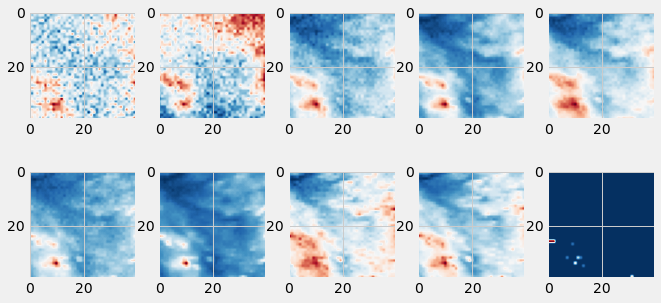

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []

for train_index, test_index in kf.split(train):
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:9]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)

    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,9]),
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)

#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:9]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)

    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,9]),
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 20, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()

Epoch 1/20
44/44 [==============================] - 40s 918ms/step - loss: 0.4107 - maeOverFscore_keras: 4.8336 - fscore_keras: 0.4217 - val_loss: 0.3131 - val_maeOverFscore_keras: 4.7589 - val_fscore_keras: 0.4306
Epoch 2/20
44/44 [==============================] - 38s 853ms/step - loss: 0.3032 - maeOverFscore_keras: 3.4718 - fscore_keras: 0.5367 - val_loss: 0.3054 - val_maeOverFscore_keras: 5.1622 - val_fscore_keras: 0.3894
Epoch 3/20
44/44 [==============================] - 38s 854ms/step - loss: 0.2911 - maeOverFscore_keras: 3.0888 - fscore_keras: 0.5782 - val_loss: 0.3000 - val_maeOverFscore_keras: 4.8571 - val_fscore_keras: 0.4064
Epoch 4/20
44/44 [==============================] - 37s 848ms/step - loss: 0.2846 - maeOverFscore_keras: 2.8843 - fscore_keras: 0.6038 - val_loss: 0.3020 - val_maeOverFscore_keras: 4.9859 - val_fscore_keras: 0.3988
Epoch 5/20
44/44 [==============================] - 37s 850ms/step - loss: 0.2778 - maeOverFscore_keras: 2.7332 - fscore_keras: 0.6217 - val

In [25]:
model

In [0]:
model.save('model_baseline.h5')
!cp model_baseline.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

## submission 만들기

In [0]:
pred = model.predict(X_test)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_baseline.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_baseline.csv '/content/drive/My Drive/2020 Kaggle Study/submission'